In [419]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
 
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras import optimizers
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, History
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'input/stage1_train/'
TEST_PATH = 'input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [355]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train_nuclei = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
Y_train_box = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
Y_train_intersection = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
mask_pad = np.zeros((IMG_HEIGHT+2, IMG_WIDTH+2))
mask_pad1 = np.zeros((IMG_HEIGHT+2, IMG_WIDTH+2))
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH))
# use mask_box to record boundaries of individual nuclei
    mask_box = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
    k = 0
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        k += 1
        mask_ = imread(path + '/masks/' + mask_file)
#         mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
#                                       preserve_range=True), axis=-1)

        mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
        
            
# detect boundaries of each mask
        mask_pad[1:(IMG_HEIGHT+1), 1:(IMG_WIDTH+1)] = (mask_)
        mask_pad = mask_pad>0
        for i in np.arange(1, (IMG_HEIGHT+1)):
            for j in np.arange(1, (IMG_WIDTH+1)):
                if (mask_pad[i, j]):
                    q = mask_pad[i-1:i+2, j-1:j+2]
                    if (False in q):
                        mask_box[i-1, j-1] = True
        mask_ = mask_>0            
        mask_ = mask_.astype(int)
        mask_ *= k 
        mask = np.maximum(mask, mask_)

# detect intersections of different nucleis                    
        mask_pad1[1:(IMG_HEIGHT+1), 1:(IMG_WIDTH+1)] = mask
        mask_inter = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
        for i in np.arange(1, (IMG_HEIGHT+1)):
            for j in np.arange(1, (IMG_WIDTH+1)):
                if (mask_pad1[i, j]>0):
                    M = mask_pad1[i-1:i+2, j-1:j+2]
                    p = mask_pad1[i,j]*(M>0)-M
                    q = (p**2)>0
                    if (True in q):
                        mask_inter[i-1, j-1] = True
    Y_train_nuclei[n] = (mask>0)
    Y_train_box[n] = mask_box
    Y_train_intersection[n] = mask_inter
    

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [17:13<00:00,  1.54s/it]


Done!


In [357]:
# save processed data. Processing the
np.save('data1/X_train', X_train)
np.save('data1/Y_train_nuclei', Y_train_nuclei)
np.save('data1/Y_train_box', Y_train_box)
np.save('data1/Y_train_intersection', Y_train_intersection)
np.save('data1/X_test', X_test)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


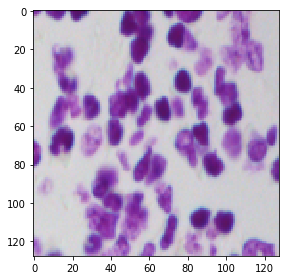

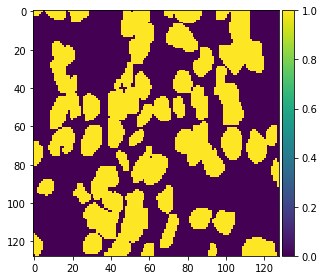

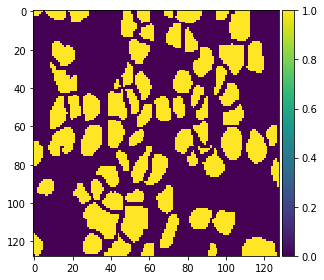

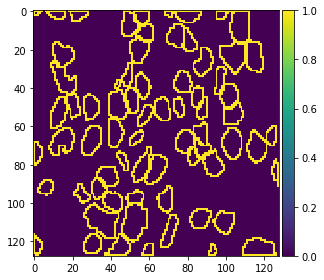

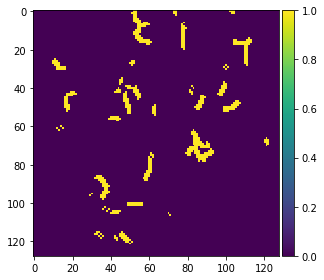

In [358]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids[0:10]))

#Training Image
imshow(X_train[ix])
plt.show()
#Ground truth nuclei image
imshow(np.squeeze(Y_train_nuclei[ix]).astype(np.uint8))
plt.show()
#Nuclei-Intrsection
imshow(np.squeeze(Y_train_nuclei[ix]^Y_train_intersection[ix]).astype(np.uint8))
plt.show()
#Boundary
imshow(np.squeeze(Y_train_box[ix]).astype(np.uint8))
plt.show()
#Intersection
imshow(np.squeeze(Y_train_intersection[ix].astype(np.uint8)))
plt.show()

In [401]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [428]:
del model

In [430]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

# output1 corresponds to nuclei pixels
output1 = Conv2D(1, (1, 1), activation='sigmoid', name='output1') (c9)

c10 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)
c11 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c10)
# output2 corresponds to boundary pixels
output2 = Conv2D(1, (1, 1), activation='sigmoid', name='output2') (c11)

model = Model(inputs=[inputs], outputs=[output1, output2])
adam = optimizers.Adam(epsilon=1e-8, decay = 5e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_15 (Lambda)              (None, 128, 128, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_265 (Conv2D)             (None, 128, 128, 16) 448         lambda_15[0][0]                  
__________________________________________________________________________________________________
dropout_127 (Dropout)           (None, 128, 128, 16) 0           conv2d_265[0][0]                 
__________________________________________________________________________________________________
conv2d_266

In [431]:
# Fit model
model_name = 'model-Unet-2class-2018-2-25-2.'
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint(model_name+'h5', verbose=1, save_best_only=True)
results = model.fit(X_train, [np.expand_dims(Y_train_nuclei, -1), np.expand_dims(Y_train_box, -1)] , validation_split=0.1, batch_size=16, epochs=100, verbose=1, callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/100
603/603 [==============================] - ETA: 7:00 - loss: 1.3701 - output1_loss: 0.7172 - output2_loss: 0.6529 - output1_acc: 0.4772 - output2_acc: 0.653 - ETA: 3:27 - loss: 1.2628 - output1_loss: 0.6724 - output2_loss: 0.5903 - output1_acc: 0.5993 - output2_acc: 0.736 - ETA: 2:16 - loss: 1.1536 - output1_loss: 0.6331 - output2_loss: 0.5205 - output1_acc: 0.6762 - output2_acc: 0.805 - ETA: 1:40 - loss: 1.1065 - output1_loss: 0.6201 - output2_loss: 0.4863 - output1_acc: 0.7162 - output2_acc: 0.835 - ETA: 1:18 - loss: 1.0811 - output1_loss: 0.6138 - output2_loss: 0.4674 - output1_acc: 0.7304 - output2_acc: 0.850 - ETA: 1:04 - loss: 1.0559 - output1_loss: 0.6010 - output2_loss: 0.4549 - output1_acc: 0.7442 - output2_acc: 0.860 - ETA: 54s - loss: 1.0234 - output1_loss: 0.5837 - output2_loss: 0.4397 - output1_acc: 0.7569 - output2_acc: 0.867 - ETA: 46s - loss: 0.9951 - output1_loss: 0.5713 - output2_loss: 0.4239 - output1_acc: 0.76

603/603 [==============================] - ETA: 5s - loss: 0.4601 - output1_loss: 0.2629 - output2_loss: 0.1972 - output1_acc: 0.8794 - output2_acc: 0.936 - ETA: 5s - loss: 0.4326 - output1_loss: 0.2438 - output2_loss: 0.1888 - output1_acc: 0.8929 - output2_acc: 0.937 - ETA: 5s - loss: 0.4450 - output1_loss: 0.2465 - output2_loss: 0.1985 - output1_acc: 0.8912 - output2_acc: 0.931 - ETA: 5s - loss: 0.4476 - output1_loss: 0.2457 - output2_loss: 0.2019 - output1_acc: 0.8934 - output2_acc: 0.927 - ETA: 5s - loss: 0.4344 - output1_loss: 0.2353 - output2_loss: 0.1991 - output1_acc: 0.8997 - output2_acc: 0.926 - ETA: 4s - loss: 0.4484 - output1_loss: 0.2446 - output2_loss: 0.2038 - output1_acc: 0.8949 - output2_acc: 0.926 - ETA: 4s - loss: 0.4457 - output1_loss: 0.2423 - output2_loss: 0.2034 - output1_acc: 0.8962 - output2_acc: 0.927 - ETA: 4s - loss: 0.4460 - output1_loss: 0.2438 - output2_loss: 0.2022 - output1_acc: 0.8947 - output2_acc: 0.929 - ETA: 4s - loss: 0.4394 - output1_loss: 0.2390

603/603 [==============================] - ETA: 5s - loss: 0.3166 - output1_loss: 0.1596 - output2_loss: 0.1571 - output1_acc: 0.9420 - output2_acc: 0.934 - ETA: 5s - loss: 0.3679 - output1_loss: 0.1875 - output2_loss: 0.1804 - output1_acc: 0.9294 - output2_acc: 0.924 - ETA: 5s - loss: 0.3712 - output1_loss: 0.1877 - output2_loss: 0.1835 - output1_acc: 0.9239 - output2_acc: 0.921 - ETA: 5s - loss: 0.3521 - output1_loss: 0.1768 - output2_loss: 0.1753 - output1_acc: 0.9294 - output2_acc: 0.925 - ETA: 5s - loss: 0.3273 - output1_loss: 0.1639 - output2_loss: 0.1633 - output1_acc: 0.9352 - output2_acc: 0.929 - ETA: 4s - loss: 0.3281 - output1_loss: 0.1644 - output2_loss: 0.1638 - output1_acc: 0.9364 - output2_acc: 0.930 - ETA: 4s - loss: 0.3196 - output1_loss: 0.1596 - output2_loss: 0.1600 - output1_acc: 0.9379 - output2_acc: 0.931 - ETA: 4s - loss: 0.3121 - output1_loss: 0.1542 - output2_loss: 0.1579 - output1_acc: 0.9399 - output2_acc: 0.932 - ETA: 4s - loss: 0.3114 - output1_loss: 0.1529

603/603 [==============================] - ETA: 5s - loss: 0.2361 - output1_loss: 0.1140 - output2_loss: 0.1221 - output1_acc: 0.9515 - output2_acc: 0.946 - ETA: 5s - loss: 0.2819 - output1_loss: 0.1389 - output2_loss: 0.1430 - output1_acc: 0.9441 - output2_acc: 0.938 - ETA: 5s - loss: 0.3223 - output1_loss: 0.1588 - output2_loss: 0.1635 - output1_acc: 0.9365 - output2_acc: 0.930 - ETA: 5s - loss: 0.3325 - output1_loss: 0.1656 - output2_loss: 0.1668 - output1_acc: 0.9351 - output2_acc: 0.929 - ETA: 5s - loss: 0.3161 - output1_loss: 0.1566 - output2_loss: 0.1595 - output1_acc: 0.9387 - output2_acc: 0.932 - ETA: 4s - loss: 0.3102 - output1_loss: 0.1523 - output2_loss: 0.1578 - output1_acc: 0.9409 - output2_acc: 0.932 - ETA: 4s - loss: 0.3218 - output1_loss: 0.1558 - output2_loss: 0.1660 - output1_acc: 0.9394 - output2_acc: 0.929 - ETA: 4s - loss: 0.3254 - output1_loss: 0.1542 - output2_loss: 0.1712 - output1_acc: 0.9398 - output2_acc: 0.925 - ETA: 4s - loss: 0.3240 - output1_loss: 0.1537

603/603 [==============================] - ETA: 5s - loss: 0.2138 - output1_loss: 0.0947 - output2_loss: 0.1191 - output1_acc: 0.9634 - output2_acc: 0.948 - ETA: 5s - loss: 0.2264 - output1_loss: 0.0995 - output2_loss: 0.1269 - output1_acc: 0.9610 - output2_acc: 0.944 - ETA: 5s - loss: 0.2365 - output1_loss: 0.1064 - output2_loss: 0.1301 - output1_acc: 0.9584 - output2_acc: 0.944 - ETA: 5s - loss: 0.2310 - output1_loss: 0.1036 - output2_loss: 0.1273 - output1_acc: 0.9596 - output2_acc: 0.945 - ETA: 5s - loss: 0.2287 - output1_loss: 0.1016 - output2_loss: 0.1271 - output1_acc: 0.9604 - output2_acc: 0.945 - ETA: 4s - loss: 0.2399 - output1_loss: 0.1074 - output2_loss: 0.1325 - output1_acc: 0.9583 - output2_acc: 0.942 - ETA: 4s - loss: 0.2399 - output1_loss: 0.1092 - output2_loss: 0.1307 - output1_acc: 0.9578 - output2_acc: 0.942 - ETA: 4s - loss: 0.2315 - output1_loss: 0.1051 - output2_loss: 0.1264 - output1_acc: 0.9593 - output2_acc: 0.944 - ETA: 4s - loss: 0.2299 - output1_loss: 0.1039

603/603 [==============================] - ETA: 5s - loss: 0.1481 - output1_loss: 0.0618 - output2_loss: 0.0863 - output1_acc: 0.9766 - output2_acc: 0.962 - ETA: 5s - loss: 0.1581 - output1_loss: 0.0652 - output2_loss: 0.0929 - output1_acc: 0.9746 - output2_acc: 0.959 - ETA: 5s - loss: 0.1732 - output1_loss: 0.0765 - output2_loss: 0.0967 - output1_acc: 0.9713 - output2_acc: 0.959 - ETA: 5s - loss: 0.1706 - output1_loss: 0.0772 - output2_loss: 0.0934 - output1_acc: 0.9720 - output2_acc: 0.960 - ETA: 5s - loss: 0.1869 - output1_loss: 0.0859 - output2_loss: 0.1010 - output1_acc: 0.9684 - output2_acc: 0.957 - ETA: 4s - loss: 0.1850 - output1_loss: 0.0860 - output2_loss: 0.0990 - output1_acc: 0.9682 - output2_acc: 0.958 - ETA: 4s - loss: 0.1974 - output1_loss: 0.0919 - output2_loss: 0.1055 - output1_acc: 0.9653 - output2_acc: 0.956 - ETA: 4s - loss: 0.2097 - output1_loss: 0.0964 - output2_loss: 0.1133 - output1_acc: 0.9632 - output2_acc: 0.951 - ETA: 4s - loss: 0.2108 - output1_loss: 0.0970

603/603 [==============================] - ETA: 5s - loss: 0.1896 - output1_loss: 0.0862 - output2_loss: 0.1035 - output1_acc: 0.9657 - output2_acc: 0.955 - ETA: 5s - loss: 0.1964 - output1_loss: 0.0907 - output2_loss: 0.1057 - output1_acc: 0.9636 - output2_acc: 0.954 - ETA: 5s - loss: 0.1934 - output1_loss: 0.0866 - output2_loss: 0.1068 - output1_acc: 0.9656 - output2_acc: 0.954 - ETA: 5s - loss: 0.2045 - output1_loss: 0.0915 - output2_loss: 0.1129 - output1_acc: 0.9636 - output2_acc: 0.951 - ETA: 5s - loss: 0.2042 - output1_loss: 0.0898 - output2_loss: 0.1144 - output1_acc: 0.9642 - output2_acc: 0.950 - ETA: 4s - loss: 0.1977 - output1_loss: 0.0860 - output2_loss: 0.1118 - output1_acc: 0.9661 - output2_acc: 0.952 - ETA: 4s - loss: 0.1996 - output1_loss: 0.0878 - output2_loss: 0.1117 - output1_acc: 0.9650 - output2_acc: 0.952 - ETA: 4s - loss: 0.1995 - output1_loss: 0.0874 - output2_loss: 0.1121 - output1_acc: 0.9652 - output2_acc: 0.952 - ETA: 4s - loss: 0.1940 - output1_loss: 0.0857

603/603 [==============================] - ETA: 5s - loss: 0.2151 - output1_loss: 0.0939 - output2_loss: 0.1212 - output1_acc: 0.9643 - output2_acc: 0.944 - ETA: 5s - loss: 0.2398 - output1_loss: 0.1044 - output2_loss: 0.1354 - output1_acc: 0.9594 - output2_acc: 0.940 - ETA: 5s - loss: 0.2233 - output1_loss: 0.1023 - output2_loss: 0.1210 - output1_acc: 0.9620 - output2_acc: 0.946 - ETA: 5s - loss: 0.2175 - output1_loss: 0.0977 - output2_loss: 0.1198 - output1_acc: 0.9629 - output2_acc: 0.946 - ETA: 5s - loss: 0.2286 - output1_loss: 0.1006 - output2_loss: 0.1280 - output1_acc: 0.9610 - output2_acc: 0.942 - ETA: 4s - loss: 0.2161 - output1_loss: 0.0939 - output2_loss: 0.1223 - output1_acc: 0.9635 - output2_acc: 0.945 - ETA: 4s - loss: 0.2135 - output1_loss: 0.0929 - output2_loss: 0.1206 - output1_acc: 0.9639 - output2_acc: 0.946 - ETA: 4s - loss: 0.2061 - output1_loss: 0.0893 - output2_loss: 0.1168 - output1_acc: 0.9652 - output2_acc: 0.947 - ETA: 4s - loss: 0.2157 - output1_loss: 0.0949

603/603 [==============================] - ETA: 5s - loss: 0.1629 - output1_loss: 0.0671 - output2_loss: 0.0958 - output1_acc: 0.9754 - output2_acc: 0.960 - ETA: 5s - loss: 0.1635 - output1_loss: 0.0698 - output2_loss: 0.0937 - output1_acc: 0.9737 - output2_acc: 0.961 - ETA: 5s - loss: 0.1711 - output1_loss: 0.0748 - output2_loss: 0.0963 - output1_acc: 0.9717 - output2_acc: 0.959 - ETA: 5s - loss: 0.1812 - output1_loss: 0.0795 - output2_loss: 0.1017 - output1_acc: 0.9690 - output2_acc: 0.956 - ETA: 5s - loss: 0.1851 - output1_loss: 0.0815 - output2_loss: 0.1036 - output1_acc: 0.9679 - output2_acc: 0.955 - ETA: 4s - loss: 0.1977 - output1_loss: 0.0880 - output2_loss: 0.1098 - output1_acc: 0.9656 - output2_acc: 0.952 - ETA: 4s - loss: 0.1921 - output1_loss: 0.0851 - output2_loss: 0.1070 - output1_acc: 0.9667 - output2_acc: 0.953 - ETA: 4s - loss: 0.2021 - output1_loss: 0.0902 - output2_loss: 0.1119 - output1_acc: 0.9647 - output2_acc: 0.951 - ETA: 4s - loss: 0.2003 - output1_loss: 0.0892

603/603 [==============================] - ETA: 5s - loss: 0.2575 - output1_loss: 0.1137 - output2_loss: 0.1438 - output1_acc: 0.9524 - output2_acc: 0.933 - ETA: 5s - loss: 0.1951 - output1_loss: 0.0859 - output2_loss: 0.1091 - output1_acc: 0.9646 - output2_acc: 0.951 - ETA: 5s - loss: 0.1866 - output1_loss: 0.0858 - output2_loss: 0.1007 - output1_acc: 0.9653 - output2_acc: 0.956 - ETA: 5s - loss: 0.1660 - output1_loss: 0.0758 - output2_loss: 0.0902 - output1_acc: 0.9696 - output2_acc: 0.961 - ETA: 5s - loss: 0.1763 - output1_loss: 0.0783 - output2_loss: 0.0980 - output1_acc: 0.9687 - output2_acc: 0.957 - ETA: 4s - loss: 0.1697 - output1_loss: 0.0746 - output2_loss: 0.0951 - output1_acc: 0.9701 - output2_acc: 0.958 - ETA: 4s - loss: 0.1699 - output1_loss: 0.0750 - output2_loss: 0.0948 - output1_acc: 0.9704 - output2_acc: 0.959 - ETA: 4s - loss: 0.1706 - output1_loss: 0.0750 - output2_loss: 0.0955 - output1_acc: 0.9702 - output2_acc: 0.959 - ETA: 4s - loss: 0.1762 - output1_loss: 0.0770

603/603 [==============================] - ETA: 5s - loss: 0.1388 - output1_loss: 0.0631 - output2_loss: 0.0757 - output1_acc: 0.9753 - output2_acc: 0.968 - ETA: 5s - loss: 0.1726 - output1_loss: 0.0783 - output2_loss: 0.0943 - output1_acc: 0.9686 - output2_acc: 0.959 - ETA: 5s - loss: 0.2009 - output1_loss: 0.0916 - output2_loss: 0.1093 - output1_acc: 0.9630 - output2_acc: 0.953 - ETA: 5s - loss: 0.1964 - output1_loss: 0.0873 - output2_loss: 0.1091 - output1_acc: 0.9644 - output2_acc: 0.952 - ETA: 5s - loss: 0.1956 - output1_loss: 0.0866 - output2_loss: 0.1090 - output1_acc: 0.9655 - output2_acc: 0.953 - ETA: 4s - loss: 0.1929 - output1_loss: 0.0850 - output2_loss: 0.1079 - output1_acc: 0.9662 - output2_acc: 0.953 - ETA: 4s - loss: 0.1897 - output1_loss: 0.0838 - output2_loss: 0.1058 - output1_acc: 0.9666 - output2_acc: 0.954 - ETA: 4s - loss: 0.1925 - output1_loss: 0.0846 - output2_loss: 0.1079 - output1_acc: 0.9665 - output2_acc: 0.953 - ETA: 4s - loss: 0.1893 - output1_loss: 0.0826

603/603 [==============================] - ETA: 5s - loss: 0.1706 - output1_loss: 0.0739 - output2_loss: 0.0967 - output1_acc: 0.9709 - output2_acc: 0.958 - ETA: 5s - loss: 0.1821 - output1_loss: 0.0778 - output2_loss: 0.1043 - output1_acc: 0.9689 - output2_acc: 0.953 - ETA: 5s - loss: 0.1901 - output1_loss: 0.0808 - output2_loss: 0.1092 - output1_acc: 0.9678 - output2_acc: 0.951 - ETA: 5s - loss: 0.1852 - output1_loss: 0.0785 - output2_loss: 0.1067 - output1_acc: 0.9687 - output2_acc: 0.952 - ETA: 5s - loss: 0.1834 - output1_loss: 0.0784 - output2_loss: 0.1050 - output1_acc: 0.9684 - output2_acc: 0.953 - ETA: 4s - loss: 0.1755 - output1_loss: 0.0747 - output2_loss: 0.1008 - output1_acc: 0.9700 - output2_acc: 0.955 - ETA: 4s - loss: 0.1795 - output1_loss: 0.0759 - output2_loss: 0.1036 - output1_acc: 0.9695 - output2_acc: 0.954 - ETA: 4s - loss: 0.1822 - output1_loss: 0.0767 - output2_loss: 0.1055 - output1_acc: 0.9690 - output2_acc: 0.953 - ETA: 4s - loss: 0.1808 - output1_loss: 0.0762

603/603 [==============================] - ETA: 5s - loss: 0.1964 - output1_loss: 0.0936 - output2_loss: 0.1028 - output1_acc: 0.9632 - output2_acc: 0.957 - ETA: 5s - loss: 0.1564 - output1_loss: 0.0697 - output2_loss: 0.0868 - output1_acc: 0.9726 - output2_acc: 0.963 - ETA: 5s - loss: 0.1509 - output1_loss: 0.0659 - output2_loss: 0.0849 - output1_acc: 0.9740 - output2_acc: 0.964 - ETA: 5s - loss: 0.1502 - output1_loss: 0.0649 - output2_loss: 0.0853 - output1_acc: 0.9745 - output2_acc: 0.963 - ETA: 5s - loss: 0.1521 - output1_loss: 0.0657 - output2_loss: 0.0864 - output1_acc: 0.9741 - output2_acc: 0.963 - ETA: 4s - loss: 0.1561 - output1_loss: 0.0666 - output2_loss: 0.0896 - output1_acc: 0.9736 - output2_acc: 0.961 - ETA: 4s - loss: 0.1567 - output1_loss: 0.0665 - output2_loss: 0.0902 - output1_acc: 0.9737 - output2_acc: 0.961 - ETA: 4s - loss: 0.1633 - output1_loss: 0.0704 - output2_loss: 0.0930 - output1_acc: 0.9725 - output2_acc: 0.959 - ETA: 4s - loss: 0.1702 - output1_loss: 0.0736

603/603 [==============================] - ETA: 5s - loss: 0.1255 - output1_loss: 0.0516 - output2_loss: 0.0738 - output1_acc: 0.9793 - output2_acc: 0.967 - ETA: 5s - loss: 0.1587 - output1_loss: 0.0673 - output2_loss: 0.0914 - output1_acc: 0.9728 - output2_acc: 0.959 - ETA: 5s - loss: 0.1812 - output1_loss: 0.0775 - output2_loss: 0.1037 - output1_acc: 0.9691 - output2_acc: 0.953 - ETA: 5s - loss: 0.1845 - output1_loss: 0.0780 - output2_loss: 0.1065 - output1_acc: 0.9690 - output2_acc: 0.952 - ETA: 4s - loss: 0.1780 - output1_loss: 0.0748 - output2_loss: 0.1032 - output1_acc: 0.9703 - output2_acc: 0.954 - ETA: 4s - loss: 0.1774 - output1_loss: 0.0756 - output2_loss: 0.1018 - output1_acc: 0.9701 - output2_acc: 0.955 - ETA: 4s - loss: 0.1773 - output1_loss: 0.0756 - output2_loss: 0.1017 - output1_acc: 0.9701 - output2_acc: 0.955 - ETA: 4s - loss: 0.1777 - output1_loss: 0.0764 - output2_loss: 0.1012 - output1_acc: 0.9699 - output2_acc: 0.955 - ETA: 4s - loss: 0.1743 - output1_loss: 0.0746

603/603 [==============================] - ETA: 5s - loss: 0.1633 - output1_loss: 0.0651 - output2_loss: 0.0981 - output1_acc: 0.9743 - output2_acc: 0.959 - ETA: 5s - loss: 0.1691 - output1_loss: 0.0669 - output2_loss: 0.1022 - output1_acc: 0.9735 - output2_acc: 0.955 - ETA: 5s - loss: 0.1574 - output1_loss: 0.0642 - output2_loss: 0.0932 - output1_acc: 0.9743 - output2_acc: 0.960 - ETA: 5s - loss: 0.1597 - output1_loss: 0.0654 - output2_loss: 0.0943 - output1_acc: 0.9736 - output2_acc: 0.959 - ETA: 5s - loss: 0.1687 - output1_loss: 0.0708 - output2_loss: 0.0980 - output1_acc: 0.9716 - output2_acc: 0.957 - ETA: 4s - loss: 0.1705 - output1_loss: 0.0720 - output2_loss: 0.0985 - output1_acc: 0.9713 - output2_acc: 0.957 - ETA: 4s - loss: 0.1736 - output1_loss: 0.0733 - output2_loss: 0.1002 - output1_acc: 0.9706 - output2_acc: 0.956 - ETA: 4s - loss: 0.1715 - output1_loss: 0.0732 - output2_loss: 0.0984 - output1_acc: 0.9709 - output2_acc: 0.957 - ETA: 4s - loss: 0.1752 - output1_loss: 0.0766

603/603 [==============================] - ETA: 5s - loss: 0.1791 - output1_loss: 0.0806 - output2_loss: 0.0985 - output1_acc: 0.9677 - output2_acc: 0.958 - ETA: 5s - loss: 0.1631 - output1_loss: 0.0706 - output2_loss: 0.0924 - output1_acc: 0.9716 - output2_acc: 0.960 - ETA: 5s - loss: 0.1711 - output1_loss: 0.0729 - output2_loss: 0.0982 - output1_acc: 0.9704 - output2_acc: 0.956 - ETA: 5s - loss: 0.1578 - output1_loss: 0.0677 - output2_loss: 0.0902 - output1_acc: 0.9726 - output2_acc: 0.960 - ETA: 5s - loss: 0.1576 - output1_loss: 0.0667 - output2_loss: 0.0910 - output1_acc: 0.9728 - output2_acc: 0.959 - ETA: 4s - loss: 0.1619 - output1_loss: 0.0684 - output2_loss: 0.0936 - output1_acc: 0.9721 - output2_acc: 0.958 - ETA: 4s - loss: 0.1541 - output1_loss: 0.0656 - output2_loss: 0.0885 - output1_acc: 0.9736 - output2_acc: 0.960 - ETA: 4s - loss: 0.1554 - output1_loss: 0.0663 - output2_loss: 0.0891 - output1_acc: 0.9732 - output2_acc: 0.960 - ETA: 4s - loss: 0.1563 - output1_loss: 0.0662

603/603 [==============================] - ETA: 5s - loss: 0.1369 - output1_loss: 0.0633 - output2_loss: 0.0736 - output1_acc: 0.9747 - output2_acc: 0.971 - ETA: 5s - loss: 0.1705 - output1_loss: 0.0871 - output2_loss: 0.0834 - output1_acc: 0.9677 - output2_acc: 0.963 - ETA: 5s - loss: 0.1581 - output1_loss: 0.0770 - output2_loss: 0.0811 - output1_acc: 0.9708 - output2_acc: 0.964 - ETA: 5s - loss: 0.1584 - output1_loss: 0.0741 - output2_loss: 0.0844 - output1_acc: 0.9720 - output2_acc: 0.963 - ETA: 5s - loss: 0.1572 - output1_loss: 0.0722 - output2_loss: 0.0850 - output1_acc: 0.9725 - output2_acc: 0.963 - ETA: 4s - loss: 0.1765 - output1_loss: 0.0802 - output2_loss: 0.0963 - output1_acc: 0.9688 - output2_acc: 0.958 - ETA: 4s - loss: 0.1752 - output1_loss: 0.0786 - output2_loss: 0.0965 - output1_acc: 0.9693 - output2_acc: 0.957 - ETA: 4s - loss: 0.1715 - output1_loss: 0.0763 - output2_loss: 0.0952 - output1_acc: 0.9701 - output2_acc: 0.958 - ETA: 4s - loss: 0.1763 - output1_loss: 0.0784

603/603 [==============================] - ETA: 5s - loss: 0.2180 - output1_loss: 0.0935 - output2_loss: 0.1245 - output1_acc: 0.9611 - output2_acc: 0.945 - ETA: 5s - loss: 0.1949 - output1_loss: 0.0825 - output2_loss: 0.1125 - output1_acc: 0.9662 - output2_acc: 0.950 - ETA: 5s - loss: 0.2064 - output1_loss: 0.0879 - output2_loss: 0.1185 - output1_acc: 0.9637 - output2_acc: 0.947 - ETA: 5s - loss: 0.1974 - output1_loss: 0.0857 - output2_loss: 0.1117 - output1_acc: 0.9647 - output2_acc: 0.950 - ETA: 5s - loss: 0.1851 - output1_loss: 0.0798 - output2_loss: 0.1052 - output1_acc: 0.9672 - output2_acc: 0.953 - ETA: 4s - loss: 0.1751 - output1_loss: 0.0748 - output2_loss: 0.1003 - output1_acc: 0.9694 - output2_acc: 0.955 - ETA: 4s - loss: 0.1730 - output1_loss: 0.0742 - output2_loss: 0.0988 - output1_acc: 0.9697 - output2_acc: 0.956 - ETA: 4s - loss: 0.1712 - output1_loss: 0.0731 - output2_loss: 0.0981 - output1_acc: 0.9702 - output2_acc: 0.957 - ETA: 4s - loss: 0.1783 - output1_loss: 0.0784

603/603 [==============================] - ETA: 5s - loss: 0.2046 - output1_loss: 0.0954 - output2_loss: 0.1093 - output1_acc: 0.9634 - output2_acc: 0.954 - ETA: 5s - loss: 0.1879 - output1_loss: 0.0851 - output2_loss: 0.1028 - output1_acc: 0.9663 - output2_acc: 0.956 - ETA: 5s - loss: 0.1835 - output1_loss: 0.0803 - output2_loss: 0.1032 - output1_acc: 0.9679 - output2_acc: 0.955 - ETA: 5s - loss: 0.1721 - output1_loss: 0.0740 - output2_loss: 0.0981 - output1_acc: 0.9703 - output2_acc: 0.957 - ETA: 5s - loss: 0.1679 - output1_loss: 0.0725 - output2_loss: 0.0953 - output1_acc: 0.9707 - output2_acc: 0.959 - ETA: 4s - loss: 0.1758 - output1_loss: 0.0760 - output2_loss: 0.0998 - output1_acc: 0.9690 - output2_acc: 0.956 - ETA: 4s - loss: 0.1660 - output1_loss: 0.0715 - output2_loss: 0.0945 - output1_acc: 0.9709 - output2_acc: 0.958 - ETA: 4s - loss: 0.1589 - output1_loss: 0.0682 - output2_loss: 0.0907 - output1_acc: 0.9722 - output2_acc: 0.960 - ETA: 4s - loss: 0.1579 - output1_loss: 0.0671

603/603 [==============================] - ETA: 5s - loss: 0.1482 - output1_loss: 0.0661 - output2_loss: 0.0822 - output1_acc: 0.9767 - output2_acc: 0.966 - ETA: 5s - loss: 0.1336 - output1_loss: 0.0590 - output2_loss: 0.0746 - output1_acc: 0.9781 - output2_acc: 0.969 - ETA: 5s - loss: 0.1506 - output1_loss: 0.0647 - output2_loss: 0.0859 - output1_acc: 0.9751 - output2_acc: 0.963 - ETA: 5s - loss: 0.1439 - output1_loss: 0.0615 - output2_loss: 0.0824 - output1_acc: 0.9758 - output2_acc: 0.965 - ETA: 5s - loss: 0.1468 - output1_loss: 0.0628 - output2_loss: 0.0840 - output1_acc: 0.9749 - output2_acc: 0.964 - ETA: 4s - loss: 0.1508 - output1_loss: 0.0650 - output2_loss: 0.0858 - output1_acc: 0.9738 - output2_acc: 0.963 - ETA: 4s - loss: 0.1547 - output1_loss: 0.0665 - output2_loss: 0.0882 - output1_acc: 0.9732 - output2_acc: 0.962 - ETA: 4s - loss: 0.1533 - output1_loss: 0.0688 - output2_loss: 0.0846 - output1_acc: 0.9732 - output2_acc: 0.963 - ETA: 4s - loss: 0.1567 - output1_loss: 0.0695

603/603 [==============================] - ETA: 5s - loss: 0.1592 - output1_loss: 0.0679 - output2_loss: 0.0913 - output1_acc: 0.9731 - output2_acc: 0.961 - ETA: 5s - loss: 0.1548 - output1_loss: 0.0638 - output2_loss: 0.0910 - output1_acc: 0.9745 - output2_acc: 0.961 - ETA: 5s - loss: 0.1433 - output1_loss: 0.0583 - output2_loss: 0.0850 - output1_acc: 0.9766 - output2_acc: 0.963 - ETA: 5s - loss: 0.1516 - output1_loss: 0.0638 - output2_loss: 0.0878 - output1_acc: 0.9748 - output2_acc: 0.962 - ETA: 5s - loss: 0.1467 - output1_loss: 0.0626 - output2_loss: 0.0841 - output1_acc: 0.9754 - output2_acc: 0.964 - ETA: 4s - loss: 0.1500 - output1_loss: 0.0632 - output2_loss: 0.0868 - output1_acc: 0.9752 - output2_acc: 0.962 - ETA: 4s - loss: 0.1574 - output1_loss: 0.0663 - output2_loss: 0.0911 - output1_acc: 0.9739 - output2_acc: 0.960 - ETA: 4s - loss: 0.1538 - output1_loss: 0.0647 - output2_loss: 0.0891 - output1_acc: 0.9744 - output2_acc: 0.961 - ETA: 4s - loss: 0.1576 - output1_loss: 0.0662

603/603 [==============================] - ETA: 5s - loss: 0.1995 - output1_loss: 0.0833 - output2_loss: 0.1162 - output1_acc: 0.9674 - output2_acc: 0.952 - ETA: 5s - loss: 0.2211 - output1_loss: 0.0916 - output2_loss: 0.1295 - output1_acc: 0.9628 - output2_acc: 0.943 - ETA: 5s - loss: 0.1842 - output1_loss: 0.0762 - output2_loss: 0.1080 - output1_acc: 0.9690 - output2_acc: 0.952 - ETA: 5s - loss: 0.1852 - output1_loss: 0.0766 - output2_loss: 0.1085 - output1_acc: 0.9684 - output2_acc: 0.951 - ETA: 5s - loss: 0.1916 - output1_loss: 0.0811 - output2_loss: 0.1105 - output1_acc: 0.9668 - output2_acc: 0.951 - ETA: 4s - loss: 0.1873 - output1_loss: 0.0805 - output2_loss: 0.1068 - output1_acc: 0.9669 - output2_acc: 0.952 - ETA: 4s - loss: 0.1804 - output1_loss: 0.0774 - output2_loss: 0.1030 - output1_acc: 0.9684 - output2_acc: 0.954 - ETA: 4s - loss: 0.1771 - output1_loss: 0.0754 - output2_loss: 0.1017 - output1_acc: 0.9692 - output2_acc: 0.955 - ETA: 4s - loss: 0.1723 - output1_loss: 0.0762

603/603 [==============================] - ETA: 5s - loss: 0.1207 - output1_loss: 0.0493 - output2_loss: 0.0714 - output1_acc: 0.9803 - output2_acc: 0.969 - ETA: 5s - loss: 0.1284 - output1_loss: 0.0550 - output2_loss: 0.0734 - output1_acc: 0.9781 - output2_acc: 0.969 - ETA: 5s - loss: 0.1455 - output1_loss: 0.0613 - output2_loss: 0.0841 - output1_acc: 0.9750 - output2_acc: 0.962 - ETA: 5s - loss: 0.1426 - output1_loss: 0.0603 - output2_loss: 0.0823 - output1_acc: 0.9755 - output2_acc: 0.963 - ETA: 5s - loss: 0.1569 - output1_loss: 0.0705 - output2_loss: 0.0863 - output1_acc: 0.9727 - output2_acc: 0.961 - ETA: 4s - loss: 0.1570 - output1_loss: 0.0692 - output2_loss: 0.0878 - output1_acc: 0.9732 - output2_acc: 0.961 - ETA: 4s - loss: 0.1550 - output1_loss: 0.0675 - output2_loss: 0.0875 - output1_acc: 0.9738 - output2_acc: 0.961 - ETA: 4s - loss: 0.1542 - output1_loss: 0.0668 - output2_loss: 0.0873 - output1_acc: 0.9738 - output2_acc: 0.961 - ETA: 4s - loss: 0.1516 - output1_loss: 0.0654

603/603 [==============================] - ETA: 5s - loss: 0.1671 - output1_loss: 0.0691 - output2_loss: 0.0980 - output1_acc: 0.9711 - output2_acc: 0.956 - ETA: 5s - loss: 0.1744 - output1_loss: 0.0750 - output2_loss: 0.0994 - output1_acc: 0.9678 - output2_acc: 0.954 - ETA: 5s - loss: 0.1528 - output1_loss: 0.0646 - output2_loss: 0.0882 - output1_acc: 0.9725 - output2_acc: 0.959 - ETA: 5s - loss: 0.1447 - output1_loss: 0.0604 - output2_loss: 0.0844 - output1_acc: 0.9745 - output2_acc: 0.961 - ETA: 5s - loss: 0.1376 - output1_loss: 0.0584 - output2_loss: 0.0791 - output1_acc: 0.9755 - output2_acc: 0.964 - ETA: 4s - loss: 0.1381 - output1_loss: 0.0583 - output2_loss: 0.0798 - output1_acc: 0.9753 - output2_acc: 0.964 - ETA: 4s - loss: 0.1364 - output1_loss: 0.0585 - output2_loss: 0.0778 - output1_acc: 0.9753 - output2_acc: 0.965 - ETA: 4s - loss: 0.1397 - output1_loss: 0.0601 - output2_loss: 0.0796 - output1_acc: 0.9748 - output2_acc: 0.964 - ETA: 4s - loss: 0.1413 - output1_loss: 0.0609

603/603 [==============================] - ETA: 5s - loss: 0.1086 - output1_loss: 0.0439 - output2_loss: 0.0647 - output1_acc: 0.9828 - output2_acc: 0.971 - ETA: 5s - loss: 0.1165 - output1_loss: 0.0460 - output2_loss: 0.0705 - output1_acc: 0.9822 - output2_acc: 0.969 - ETA: 5s - loss: 0.1374 - output1_loss: 0.0618 - output2_loss: 0.0755 - output1_acc: 0.9777 - output2_acc: 0.966 - ETA: 5s - loss: 0.1293 - output1_loss: 0.0565 - output2_loss: 0.0728 - output1_acc: 0.9792 - output2_acc: 0.968 - ETA: 5s - loss: 0.1358 - output1_loss: 0.0590 - output2_loss: 0.0769 - output1_acc: 0.9781 - output2_acc: 0.966 - ETA: 4s - loss: 0.1395 - output1_loss: 0.0599 - output2_loss: 0.0796 - output1_acc: 0.9773 - output2_acc: 0.965 - ETA: 4s - loss: 0.1417 - output1_loss: 0.0601 - output2_loss: 0.0816 - output1_acc: 0.9770 - output2_acc: 0.964 - ETA: 4s - loss: 0.1386 - output1_loss: 0.0584 - output2_loss: 0.0802 - output1_acc: 0.9777 - output2_acc: 0.964 - ETA: 4s - loss: 0.1437 - output1_loss: 0.0607

In [432]:
# Predict on train, val and test
model = load_model(model_name+'h5', custom_objects={'mean_iou': mean_iou})
preds_train_nu, preds_train_box = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val_nu, preds_val_box = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test_nu, preds_test_box = model.predict(X_test, verbose=1)
# model = load_model(model_name+'h5', custom_objects={'mean_iou': mean_iou})
# preds_train_nu= model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
# preds_val_nu = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
# preds_test_nu = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_nu_t = (preds_train_nu > 0.5).astype(np.uint8)
preds_val_nu_t = (preds_val_nu > 0.5).astype(np.uint8)
preds_test_nu_t = (preds_test_nu > 0.5).astype(np.uint8)

preds_train_box_t = (preds_train_box > 0.5).astype(np.uint8)
preds_val_box_t= (preds_val_box > 0.5).astype(np.uint8)
preds_test_box_t = (preds_test_box > 0.5).astype(np.uint8)


65/65 [==============================] - ETA:  - ETA:  - 0s 2ms/step


In [396]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test_nu_t)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


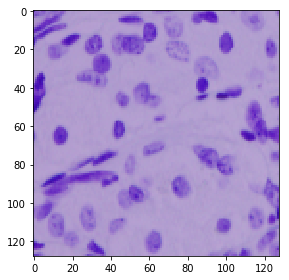

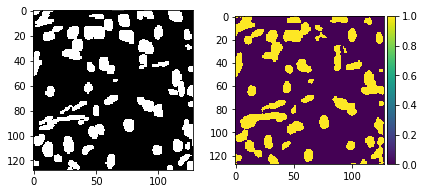

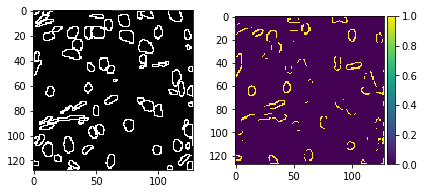

In [475]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()

plt.subplot(121)
imshow(np.squeeze(Y_train_nuclei[ix]))
plt.subplot(122)
imshow(np.squeeze(preds_train_nu_t[ix]))
plt.show()

plt.subplot(121)
imshow(np.squeeze(Y_train_box[ix]))
plt.subplot(122)
imshow(np.squeeze(preds_train_box_t[ix]))
plt.show()



# imshow((np.squeeze(preds_train_nu_t[ix,:,:]).astype(float)-np.squeeze(preds_train_box_t[ix,:,:]).astype(float))>0)
# plt.show()

# imshow(np.squeeze(Y_train[ix,:,:,1]))
# plt.show()
# imshow(np.squeeze(preds_train_box_t[ix,:,:]))
# plt.show()

In [199]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [389]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n], cutoff = 0.5))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [390]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv(model_name+'csv', index=False)